In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import PowerNorm

In [2]:
# Parameters
reporting_rate = 0.18
filename = '../data/newport_raw.csv'

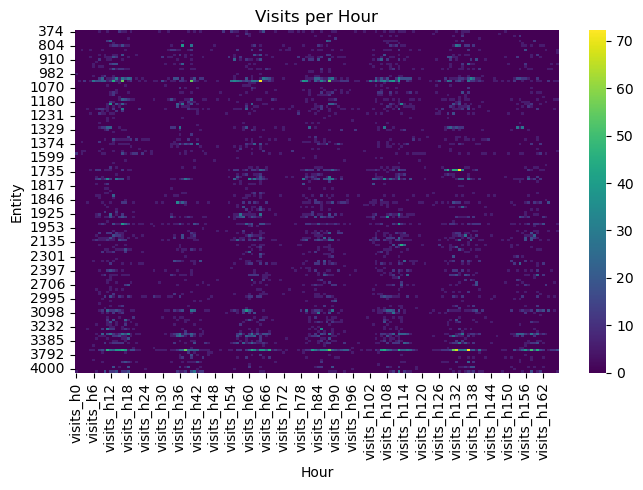

In [3]:
# Load data
df = pd.read_csv(filename, dtype=str)

df.columns = df.columns.str.lower()

visits_cols = [
  col for col in df.columns 
  if re.match(r'^visits_h\d+$', col)
]

df[visits_cols] = df[visits_cols].apply(
  pd.to_numeric, 
  errors='coerce'
)

df[visits_cols] = df[visits_cols] / reporting_rate

df = df.rename(columns={'build_id': 'loc_id'})

#df['_is_res'] = df['prim_occ'] == 'Single Family Dwelling'
#df = df.sort_values(by='_is_res')  
#df = df.drop(columns=['_is_res']) 

# Verify
do_plot = True
if do_plot:
  visits_surface = df[visits_cols].astype(float).dropna()

  plt.figure(figsize=(7, 5))
  sns.heatmap(visits_surface, cmap='viridis', cbar=True)

  plt.xlabel("Hour")
  plt.ylabel("Entity")
  plt.title("Visits per Hour")
  plt.tight_layout()
  plt.show()

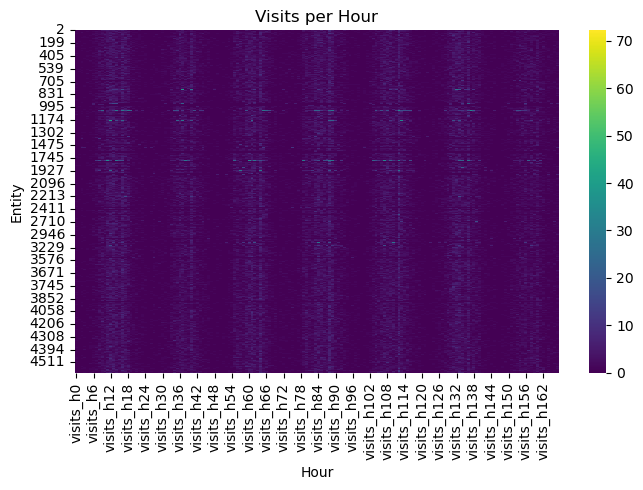

In [4]:
# Augment data to fill on all non-residential locations that were not observed
flag = df['prim_occ'] != 'Single Family Dwelling'

nonres_df = df[flag]
nonres_visits = nonres_df[visits_cols].apply(pd.to_numeric, errors='coerce')
mean_nonres_visits = nonres_visits.mean()

# Only fill NaNs with Poisson-sampled values
for col in visits_cols:
    missing = df.loc[flag, col].isna()
    n_missing = missing.sum()
    if n_missing > 0:
        poisson_samples = np.random.poisson(mean_nonres_visits[col], size=n_missing)
        # Get the index labels where values are missing
        idx_missing = df.loc[flag, col][missing].index
        # Assign
        df.loc[idx_missing, col] = poisson_samples



# Verify
do_plot = True
if do_plot:
  visits_surface = df[visits_cols].astype(float).dropna()

  plt.figure(figsize=(7, 5))
  sns.heatmap(visits_surface, cmap='viridis', cbar=True)

  plt.xlabel("Hour")
  plt.ylabel("Entity")
  plt.title("Visits per Hour")
  plt.tight_layout()
  plt.show()

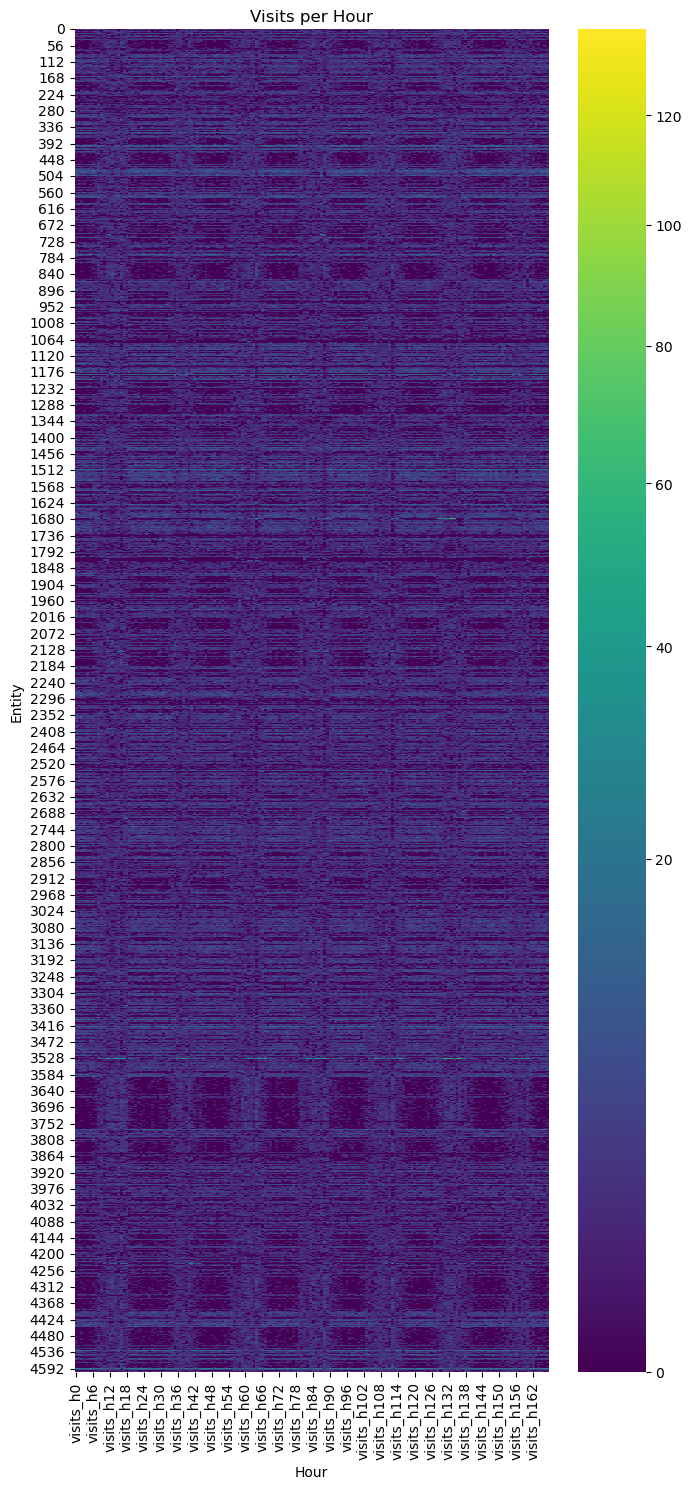

In [5]:
# Fill in residential visits by mass balance
nonres_flag = df['prim_occ'] != 'Single Family Dwelling'
res_flag = ~nonres_flag

nonres_sum = df.loc[nonres_flag, visits_cols].sum()

city_pop = 10489

residual = city_pop - nonres_sum  

n_res = res_flag.sum()

res_sqmeters = df.loc[res_flag, 'sqmeters'].astype(float).values
total_sqmeters = res_sqmeters.sum()
res_weights = res_sqmeters / total_sqmeters  # Proportional weights

visits_per_residence = np.outer(res_weights, residual.values)  # shape: (n_res, n_hour)

visits_per_residence_noisy = np.random.poisson(lam=visits_per_residence)

df.loc[res_flag, visits_cols] = visits_per_residence_noisy

# Verify
do_plot = True
if do_plot:
  visits_surface = df[visits_cols].astype(float)

  plt.figure(figsize=(7, 15))
  sns.heatmap(visits_surface, cmap='viridis', cbar=True, norm = PowerNorm(gamma=0.5))

  plt.xlabel("Hour")
  plt.ylabel("Entity")
  plt.title("Visits per Hour")
  plt.tight_layout()
  plt.show()


In [6]:
# Melt to location, time, visit count
tr = df.melt(
  id_vars=['loc_id'], 
  value_vars=visits_cols, 
  var_name='hour_of_week', 
  value_name='visits'
)

tr['hour_of_week'] = tr['hour_of_week'].str.extract(r'(\d+)').astype(int)
tr['t'] = tr['hour_of_week'] % 24 / 24

tr = tr.groupby(['loc_id', 't'], observed=True)['visits'].mean().reset_index()

In [34]:
# Save
tr.to_csv('../data/visits_by_loc_and_t.csv', index=False)